# ***Plagiarism Detection before Sampling process***

*Initiliasing all the libraries in the beginning*

In [ ]:
# !pip install fast_ml
# from fast_ml.model_development import train_valid_test_split
!pip install -q -U keras-tuner
!pip install visualkeras

     |████████████████████████████████| 133 kB 7.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 5.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import sklearn.metrics
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import re
import imblearn
import collections
import seaborn as sns

In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers,layers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy,CategoricalCrossentropy
from keras.models import model_from_json
from matplotlib import pyplot as plt


***Geting the feature dataset and label using pandas***

In [ ]:
  df=pd.read_csv('/content/sample_data/plagiarism_student_dataset_features.csv',index_col=0)
  df.index.names=[None]
  print(df.dtypes)
  df.describe()

total_time               float64
compiled                 float64
compiled_successfully    float64
ran_tests                float64
test_results             float64
modified                 float64
add_lines                float64
change                   float64
remove_lines             float64
cps                      float64
paste_lines              float64
max_pastes               float64
average_test_results     float64
avg_paste                float64
dtype: object


,total_time,compiled,compiled_successfully,ran_tests,test_results,modified,add_lines,change,remove_lines,cps,paste_lines,max_pastes,average_test_results,avg_paste
count,2.320000e+03,1871.000000,1848.000000,1806.000000,1648.000000,2328.000000,2007.000000,1878.000000,1972.000000,2240.000000,1915.000000,1915.000000,1648.000000,1915.000000
mean,3.962753e+06,1225.227151,825.373918,485.394795,615.199636,19741.609107,15007.514699,20594.829073,2564.556288,0.038880,10881.229243,239.545692,1.277133,5.251724
std,4.130006e+06,1304.327330,908.102890,423.561568,637.911940,20704.213805,35047.747797,17131.208105,14440.750302,0.604302,34453.639701,724.122757,1.059974,11.343774
min,0.000000e+00,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,6.000000,1.000000,0.000000,1.000000
25%,1.765960e+05,245.000000,160.000000,151.000000,175.750000,218.500000,1696.500000,6155.250000,269.000000,0.001328,1057.000000,64.000000,0.614717,2.606246
50%,2.815448e+06,879.000000,559.500000,402.500000,427.500000,14424.500000,7859.000000,17921.500000,1044.500000,0.003528,3967.000000,139.000000,1.029409,3.864455
75%,6.460800e+06,1718.500000,1158.750000,712.750000,874.500000,32804.750000,16062.500000,30846.750000,2240.000000,0.007138,8576.000000,263.000000,1.615406,5.552023
max,2.297714e+07,10723.000000,7322.000000,3087.000000,8574.000000,113231.000000,521578.000000,98826.000000,378687.000000,22.750000,511649.000000,20000.000000,10.000000,432.557784


In [ ]:
label_A=pd.read_csv('/content/sample_data/label_for_plagiarism_dataset_stat_dynamic.csv',index_col=0)
label_A.index.names=[None]
label_A.describe()

,label
count,2339.000000
mean,0.284310
std,0.451181
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:

df.head()

,total_time,compiled,compiled_successfully,ran_tests,test_results,modified,add_lines,change,remove_lines,cps,paste_lines,max_pastes,average_test_results,avg_paste
A2016\student1013,6894752.0,1441.0,1116.0,689.0,1349.0,38441.0,12365.0,32597.0,2023.0,0.003436,5202.0,120.0,1.957910,4.553441
A2016\student1016,37440.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,8.0,0.000000,NaN,NaN,NaN,NaN
A2016\student1021,9363152.0,2108.0,1278.0,787.0,1605.0,58550.0,19160.0,49003.0,6105.0,0.003997,7270.0,162.0,2.039390,5.147455
A2016\student1029,6949656.0,1775.0,1201.0,852.0,754.0,36461.0,15605.0,30332.0,2683.0,0.005040,7235.0,165.0,0.884977,4.840774
A2016\student1066,2784368.0,338.0,223.0,449.0,810.0,13924.0,6140.0,12169.0,369.0,0.004970,3988.0,139.0,1.804009,3.470160


In [ ]:
label_A.head()

,label
A2016\student1013,0
A2016\student1016,0
A2016\student1021,1
A2016\student1029,1
A2016\student1066,0


In [ ]:
label_list = label_A['label'].tolist()

In [ ]:
print(label_list[:10])
print(len(label_list))

[0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
2339


In [ ]:
df['label']=label_list
df.fillna(0,inplace=True)
# df.dropna(inplace = True)
trainA=df.iloc[:,:-1]
label_A=df.iloc[:,-1]

In [ ]:
trainA.head()

,total_time,compiled,compiled_successfully,ran_tests,test_results,modified,add_lines,change,remove_lines,cps,paste_lines,max_pastes,average_test_results,avg_paste
A2016\student1013,6894752.0,1441.0,1116.0,689.0,1349.0,38441.0,12365.0,32597.0,2023.0,0.003436,5202.0,120.0,1.957910,4.553441
A2016\student1016,37440.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.000000,0.000000
A2016\student1021,9363152.0,2108.0,1278.0,787.0,1605.0,58550.0,19160.0,49003.0,6105.0,0.003997,7270.0,162.0,2.039390,5.147455
A2016\student1029,6949656.0,1775.0,1201.0,852.0,754.0,36461.0,15605.0,30332.0,2683.0,0.005040,7235.0,165.0,0.884977,4.840774
A2016\student1066,2784368.0,338.0,223.0,449.0,810.0,13924.0,6140.0,12169.0,369.0,0.004970,3988.0,139.0,1.804009,3.470160


In [ ]:
label_A.head()

A2016\student1013    0
A2016\student1016    0
A2016\student1021    1
A2016\student1029    1
A2016\student1066    0
Name: label, dtype: int64

***The count of plagiarised and not plagiarised dataset available to us which is skewed, as the count of not plagiarised is greater than the count of plagiarised***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


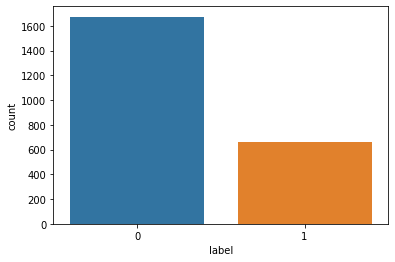

In [ ]:
sns.countplot(label_A)

***Scaling the values of features between 0 to 1 for better results and classification***

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
train_A=scaler.fit_transform(trainA)

In [ ]:
print(train_A.dtype)
print(train_A.shape)
print(train_A)

float64
(2339, 14)
[[3.00070017e-01 1.34384034e-01 1.52417372e-01 ... 6.00000000e-03
  1.95791002e-01 1.05267808e-02]
 [1.62944533e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.07498512e-01 1.96586776e-01 1.74542475e-01 ... 8.10000000e-03
  2.03939009e-01 1.19000408e-02]
 ...
 [5.37605544e-01 5.28676676e-01 4.87298552e-01 ... 1.16000000e-02
  6.28982528e-02 1.11948382e-02]
 [3.69758748e-04 0.00000000e+00 0.00000000e+00 ... 1.00000000e-04
  0.00000000e+00 3.39974979e-03]
 [2.87237439e-01 1.54714166e-01 1.35618683e-01 ... 1.62500000e-02
  1.02476780e-01 1.58131852e-02]]


In [ ]:
label_A=label_A.to_numpy()
print(label_A.dtype)
# label_A=label_A.astype(float)
print(label_A.shape)
print(label_A)

int64
(2339,)
[0 0 1 ... 0 0 0]


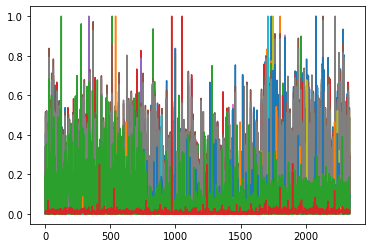

In [ ]:
plt.plot(train_A)

***Splitting the dataset into training and testing with a train_size split of 0.8***

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(train_A,label_A,train_size=0.8)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1871, 14)
(1871,)
(468, 14)
(468,)


***The callbacks are defined here to stop training the model when there is no change in the parameter we wish to monitor***

In [ ]:
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    min_delta=0, 
    mode='max',
    restore_best_weights=True

)
custom_early_stopping_loss = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=0, 
    mode='min',
    restore_best_weights=True
)
custom_early_stopping_recall=EarlyStopping(
    monitor='val_recall', 
    patience=5, 
    min_delta=0, 
    mode='max',
    restore_best_weights=True
)

# reduce_lr callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=2
)
# lr_decay callback
def lr_decay(epoch, lr):
    if epoch != 0 and epoch % 5 == 0:
        return lr * 0.2
    return lr

# modelcheckpoint callback
filepath = 'my_best_model_acc{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

***A sequential model is built in the function using keras tuner which selects the best model for the inputs based on the range of layers given(2-40) and number of neurons between 16-512 with a step size of 32 and also the learning rate. It selects the best hyperparameters based on the input dataset provided***

In [ ]:
def build_model(hp):
  model=keras.Sequential()
  
  for layer in range(hp.Int('num_layers',2,30)):
    model.add(layers.Dense(units=hp.Int('units' + str(layer),
                                            min_value=16,
                                            max_value=512,
                                            step=32),
                               activation='relu')),
    # model.add(layers.BatchNormalization(axis=1)),
    # model.add(layers.Dropout(rate=hp.Float('dropout_1',min_value=0.1,max_value=1.0,step=0.05))),
  model.add(layers.Dense(units=1,activation='sigmoid'))
  model.compile(optimizer=SGD(hp.Choice('learning_rate',[1e-2, 1e-3, 1e-4,1e-5,1e-6,1e-7])),
                              loss=keras.losses.BinaryCrossentropy(),metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
  return model 

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_accuracy",direction="max"),
    max_trials=3,
    executions_per_trial=5,
    # directory='/Users/rhuthuhegde/Desktop/Others/Final Year Project Files/project',
    directory='project2',
    overwrite=True,
    project_name='Plagiarism Detection')

In [ ]:
# build_model.summary()
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 1, 'sampling': None}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 32, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07], 'ordered': True}


In [ ]:
tuner.search(x_train,
          y_train,
          epochs=100,
          validation_split=0.25,
          callbacks=[custom_early_stopping_recall,reduce_lr]
                )

Trial 3 Complete [00h 00m 52s]
val_accuracy: 0.6547008574008941

Best val_accuracy So Far: 0.6940170764923096
Total elapsed time: 00h 02m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project2/Plagiarism Detection
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 4
units0: 272
units1: 144
learning_rate: 1e-05
units2: 240
units3: 304
units4: 240
units5: 112
units6: 48
units7: 112
units8: 80
units9: 272
units10: 336
units11: 240
units12: 304
units13: 208
units14: 176
Score: 0.6940170764923096
Trial summary
Hyperparameters:
num_layers: 9
units0: 432
units1: 272
learning_rate: 1e-07
units2: 144
units3: 400
units4: 336
units5: 176
units6: 432
units7: 112
units8: 432
units9: 112
units10: 368
units11: 368
units12: 400
units13: 144
units14: 144
Score: 0.6547008574008941
Trial summary
Hyperparameters:
num_layers: 15
units0: 432
units1: 432
learning_rate: 1e-07
units2: 16
units3: 16
units4: 16
units5: 16
units6: 16
units7: 16
units8: 16
units9: 16
units10: 16
units11: 16
units12: 16
units13: 16
units14: 16
Score: 0.626068377494812


***The model with best validation accuracy is chosen after searching it using RandomSearch***

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('num_layers'))
print(best_hps.get('learning_rate'))

4
1e-05


***The best model is built and fit on the dataset. The model is also retrained to get better accuracy and recall values***

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=100, validation_split=0.25,callbacks=[custom_early_stopping,reduce_lr])
# val_acc_per_epoch=history.history['val_loss']
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
44/44 [==============================] - 2s 14ms/step - loss: 0.6915 - accuracy: 0.6935 - precision_1: 0.1500 - recall_1: 0.0232 - val_loss: 0.6917 - val_accuracy: 0.7073 - val_precision_1: 0.1667 - val_recall_1: 0.0155 - lr: 1.0000e-05
Epoch 2/100
44/44 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.7028 - precision_1: 0.1915 - recall_1: 0.0232 - val_loss: 0.6917 - val_accuracy: 0.7137 - val_precision_1: 0.1429 - val_recall_1: 0.0078 - lr: 1.0000e-05
Epoch 3/100
44/44 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.7042 - precision_1: 0.2000 - recall_1: 0.0232 - val_loss: 0.6916 - val_accuracy: 0.7137 - val_precision_1: 0.1429 - val_recall_1: 0.0078 - lr: 1.0000e-05
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.7071 - precision_1: 0.2195 - recall_1: 0.0232 - val_loss: 0.6916 - val_accuracy: 0.7158 - val_precision_1: 0.1667 - val_recall_1: 0.0078 - lr: 1.0000e-05
Epoch 5

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2,callbacks=[reduce_lr,custom_early_stopping],shuffle=True)

47/47 [==============================] - 1s 13ms/step - loss: 0.6933 - accuracy: 0.5127 - precision_2: 0.2451 - recall_2: 0.3639 - val_loss: 0.6932 - val_accuracy: 0.5733 - val_precision_2: 0.2623 - val_recall_2: 0.3137 - lr: 1.0000e-05


In [ ]:
from statistics import median, mode
eval_result = hypermodel.evaluate(x_test, y_test)
eval_result_train=hypermodel.evaluate(x_train,y_train)
eval_result
print("[test loss, test accuracy,test precision,test recall]:", eval_result)# print(predictions.dtype)
predictions=hypermodel.predict(x_test)

print(sum(predictions)/len(predictions))
print(median(predictions))
val=min(sum(predictions)/len(predictions),median(predictions))
predictions

59/59 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5639 - precision_2: 0.2704 - recall_2: 0.3404
[test loss, test accuracy,test precision,test recall]: [0.6932815313339233, 0.5641025900840759, 0.32278481125831604, 0.3445945978164673]
[0.49992266]
[0.49995512]


array([[0.50137734],
       [0.50046945],
       [0.4994098 ],
       [0.49916357],
       [0.49995437],
       [0.4998432 ],
       [0.4999546 ],
       [0.4990388 ],
       [0.49998257],
       [0.49856937],
       [0.49996346],
       [0.4999564 ],
       [0.4999648 ],
       [0.49995708],
       [0.49908006],
       [0.5000392 ],
       [0.5000699 ],
       [0.49939945],
       [0.50016946],
       [0.49995536],
       [0.50190747],
       [0.5007183 ],
       [0.49999458],
       [0.4999564 ],
       [0.4998228 ],
       [0.49995914],
       [0.49989086],
       [0.49962327],
       [0.4999516 ],
       [0.5029465 ],
       [0.4999775 ],
       [0.49991086],
       [0.5003546 ],
       [0.5000183 ],
       [0.49951872],
       [0.4995029 ],
       [0.5000084 ],
       [0.50089496],
       [0.5000971 ],
       [0.49980006],
       [0.49982122],
       [0.49996436],
       [0.49905333],
       [0.50008166],
       [0.50017804],
       [0.5011997 ],
       [0.50012594],
       [0.499

*Here is the graph showing the performance of the training and testing data after fitting the model on the dataset after first try*

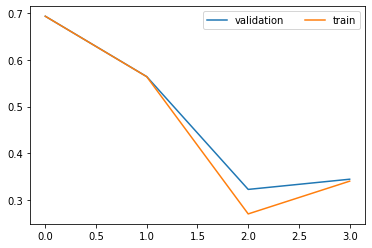

In [ ]:
plt.plot(eval_result,label="validation")
plt.plot(eval_result_train,label="train")
plt.legend(ncol=2)

In [ ]:
print(predictions.shape)
seq_predictions=np.transpose(predictions)[0]  # transformation to get (n,)
print(seq_predictions.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
seq_predictions = list(map(lambda x: 0 if x< val else 1, seq_predictions))

(468, 1)
(468,)


In [ ]:
loss,acc,pre,rec=hypermodel.evaluate(x_train,y_train)
print(acc)
loss,acc,pre,rec=hypermodel.evaluate(x_test,y_test)
print(acc)

59/59 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5639 - precision_2: 0.2704 - recall_2: 0.3404
0.5638695955276489
15/15 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5641 - precision_2: 0.3228 - recall_2: 0.3446
0.5641025900840759


In [ ]:
# save the file in json
model_json = hypermodel.to_json()
with open("model_acctest_71.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
hypermodel.save_weights("model_acctest_71.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load the model from json
json_file = open('model_acctest_71.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_acctest_71.h5")
print("Loaded model from disk")

Loaded model from disk


***The saved and loaded model is compiled and evaluated again on the training and test dataset to give us the following results***

In [ ]:
# loading the model from disk and calculating the recall and accuracy
loaded_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy',keras.metrics.Recall(),keras.metrics.AUC()])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
score_train=loaded_model.evaluate(x_train,y_train,verbose=0)
print("For testing data")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score[3]*100))
print("For training data")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score_train[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score_train[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score_train[3]*100))

For testing data
accuracy: 68.38%
recall_7: 0.00%
auc_4: 50.00%
For training data
accuracy: 72.37%
recall_7: 0.00%
auc_4: 50.00%


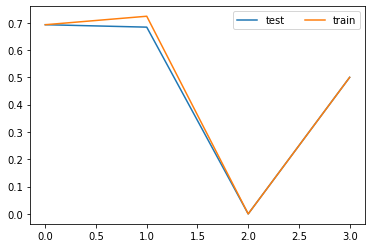

In [ ]:
plt.plot(score,label="test")
plt.plot(score_train,label="train")
plt.legend(ncol=2)

***The loaded model is compiled and fit again to give us better results of accuracy and recall which is 68.4 and 91.1 respectively after the sampling process***

In [ ]:
# retrain the model
loaded_model.fit(x_train,y_train,epochs=100,validation_split=0.2,use_multiprocessing=True,callbacks=[custom_early_stopping,reduce_lr])

Epoch 1/100
47/47 [==============================] - 2s 6ms/step - loss: 0.6698 - accuracy: 0.7226 - recall_7: 0.0000e+00 - auc_4: 0.4903 - val_loss: 0.6481 - val_accuracy: 0.7280 - val_recall_7: 0.0000e+00 - val_auc_4: 0.5000 - lr: 0.0100
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.7226 - recall_7: 0.0000e+00 - auc_4: 0.5007 - val_loss: 0.6218 - val_accuracy: 0.7280 - val_recall_7: 0.0000e+00 - val_auc_4: 0.5000 - lr: 0.0100
Epoch 3/100
32/47 [===================>..........] - ETA: 0s - loss: 0.6132 - accuracy: 0.7334 - recall_7: 0.0000e+00 - auc_4: 0.5081
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
47/47 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.7226 - recall_7: 0.0000e+00 - auc_4: 0.4853 - val_loss: 0.6065 - val_accuracy: 0.7280 - val_recall_7: 0.0000e+00 - val_auc_4: 0.5000 - lr: 0.0100
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.6083 - 

In [ ]:
# save the file in json
model_json = hypermodel.to_json()
with open("model_acctest_71.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
hypermodel.save_weights("model_acctest_71.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load the model from json
json_file = open('model_acctest_71.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_acctest_71.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# loading the model from disk and calculating the recall and accuracy
loaded_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy',keras.metrics.Recall(),keras.metrics.AUC()])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
score_train=loaded_model.evaluate(x_train,y_train,verbose=0)
print("For testing data")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score[3]*100))
print("For training data")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score_train[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score_train[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score_train[3]*100))

For testing data
accuracy: 56.41%
recall_8: 34.46%
auc_5: 48.40%
For training data
accuracy: 56.39%
recall_8: 34.04%
auc_5: 50.09%


*The performance graph after fitting the model 2nd time for better performance*


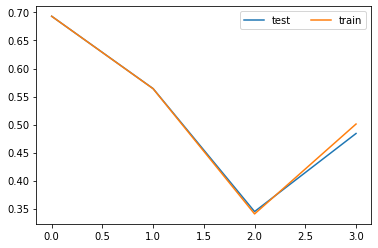

In [ ]:
plt.plot(score,label="test")
plt.plot(score_train,label="train")
plt.legend(ncol=2)

***Visualizing the neural network based on the density of each layer***

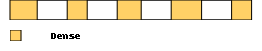

In [ ]:
import visualkeras
visualkeras.layered_view(loaded_model).show() # display using your system viewer
visualkeras.layered_view(loaded_model, to_file='output.png') # write to disk
visualkeras.layered_view(loaded_model, to_file='output.png').show() # write and show

visualkeras.layered_view(loaded_model, legend=True, draw_volume=False,spacing=30)

In [ ]:
from statistics import median, mode
eval_result = loaded_model.evaluate(x_test, y_test)
eval_result
print("[test loss, test accuracy,test precision,test recall]:", eval_result)
predictions=loaded_model.predict(x_test)

print(sum(predictions)/len(predictions))
print(median(predictions))
val=min(sum(predictions)/len(predictions),median(predictions))
predictions

15/15 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5641 - recall_8: 0.3446 - auc_5: 0.4840
[test loss, test accuracy,test precision,test recall]: [0.6932815313339233, 0.5641025900840759, 0.3445945978164673, 0.4839949309825897]
[0.49992266]
[0.49995512]


array([[0.50137734],
       [0.50046945],
       [0.4994098 ],
       [0.49916357],
       [0.49995437],
       [0.4998432 ],
       [0.4999546 ],
       [0.4990388 ],
       [0.49998257],
       [0.49856937],
       [0.49996346],
       [0.4999564 ],
       [0.4999648 ],
       [0.49995708],
       [0.49908006],
       [0.5000392 ],
       [0.5000699 ],
       [0.49939945],
       [0.50016946],
       [0.49995536],
       [0.50190747],
       [0.5007183 ],
       [0.49999458],
       [0.4999564 ],
       [0.4998228 ],
       [0.49995914],
       [0.49989086],
       [0.49962327],
       [0.4999516 ],
       [0.5029465 ],
       [0.4999775 ],
       [0.49991086],
       [0.5003546 ],
       [0.5000183 ],
       [0.49951872],
       [0.4995029 ],
       [0.5000084 ],
       [0.50089496],
       [0.5000971 ],
       [0.49980006],
       [0.49982122],
       [0.49996436],
       [0.49905333],
       [0.50008166],
       [0.50017804],
       [0.5011997 ],
       [0.50012594],
       [0.499

In [ ]:
print(predictions.shape)
seq_predictions=np.transpose(predictions)[0]  # transformation to get (n,)
print(seq_predictions.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
seq_predictions = list(map(lambda x: 0 if x< val else 1, seq_predictions))

(468, 1)
(468,)


***The working of the dataset on the testing data and comparing it with its label gives us the confusion matrix which has a better recall. Recall is an important factor as higher recall implies that the model can predict plagiarised assignments almost 90% of the times***

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_test,seq_predictions)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[104 216]
 [ 88  60]]


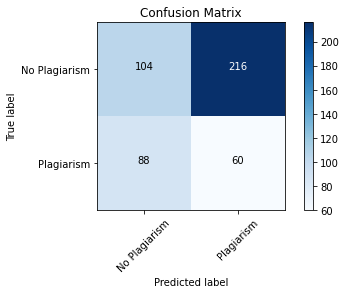

In [ ]:
cm_plot_labels = ['No Plagiarism','Plagiarism']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
print("Accuracy",sklearn.metrics.accuracy_score(y_test,seq_predictions))
print("Recall",sklearn.metrics.recall_score(y_test,seq_predictions))
print("ROC AUC",sklearn.metrics.roc_auc_score(y_test,seq_predictions))
print("F1",sklearn.metrics.f1_score(y_test,seq_predictions))

Accuracy 0.3504273504273504
Recall 0.40540540540540543
ROC AUC 0.3652027027027027
F1 0.2830188679245283


***Testing on the B2017 dataset to generate the output***

In [ ]:
from numpy import asarray
# values=[
# 7216624.0,2786.0,1682.0,810.0,499.0,30029.0,18276.0,24492.0,1321.0,0.00542927,10928.0,469.0,0.616049383,3.585377013    
#    ]
test_2017=pd.read_csv('/content/sample_data/plagiarism_student_dataset_test_B2017.csv',index_col=0)
test_2017.index.names=[None]
test_2017.fillna(0,inplace=True)
test_2017.describe()
test_2017=scaler.fit_transform(test_2017)
# values=np.array(values).reshape(-1,1)
# values=scaler.fit_transform(values)
# val=(max(values)+min(values))/2
# print(val)
# print(values)
# input_array = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
# values = np.expand_dims(values,axis=0)
label=loaded_model.predict(test_2017)
val=min(sum(label)/len(label),median(label))
print(label)
for i in label:
  print("Plagiarised" if i>val else "Non Plagiarised")
print(val)
print(label.dtype)
# sns.countplot(label)

[[0.4999454 ]
 [0.4974359 ]
 [0.49996933]
 [0.49927315]
 [0.4999032 ]
 [0.49783513]
 [0.49995008]
 [0.49812725]
 [0.49957728]
 [0.49995738]
 [0.5006214 ]
 [0.5003735 ]
 [0.4989935 ]
 [0.5002188 ]
 [0.4986722 ]
 [0.49996957]
 [0.49853417]
 [0.49821433]
 [0.4999705 ]
 [0.49793327]
 [0.49994478]
 [0.4989915 ]
 [0.49995664]
 [0.4999546 ]
 [0.50072116]
 [0.4999525 ]
 [0.49881396]
 [0.49995452]
 [0.4979816 ]
 [0.5002376 ]
 [0.5000114 ]
 [0.5001566 ]
 [0.5005501 ]
 [0.5001489 ]
 [0.49659395]
 [0.5001875 ]
 [0.5008973 ]
 [0.49995622]
 [0.49857843]
 [0.4999557 ]
 [0.49899045]
 [0.4988927 ]
 [0.5007148 ]
 [0.49996513]
 [0.50190705]
 [0.49872422]
 [0.4983096 ]
 [0.5001183 ]
 [0.49829635]
 [0.49843645]
 [0.49735466]
 [0.49807504]
 [0.5004192 ]
 [0.49918294]
 [0.50016797]
 [0.49971768]
 [0.49693263]
 [0.49993643]
 [0.49995625]
 [0.4999541 ]
 [0.4999979 ]
 [0.49917018]
 [0.49905384]
 [0.49939966]
 [0.4999547 ]
 [0.49995694]
 [0.500047  ]
 [0.50004405]
 [0.4994828 ]
 [0.49677986]
 [0.5007062 ]
 [0.49

# ***In conclusion we can say that the model after sampling performs better than the model before sampling with better recall and accuracy***